In [1]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import pandas as pd
from cartopy.feature import NaturalEarthFeature
from matplotlib.patches import Circle
from shapely.geometry.point import Point
import matplotlib.font_manager as fm


### Plot Map

#### Read Image_list

In [2]:
# Read Image_list.xlsx
whale_list = pd.read_excel(r"C:\Users\zyj19\Desktop\Whales\DFO\Imagery list.xlsx", sheet_name='AOI')
print(whale_list.head(1))

      Order Number    Location       Date  Sat  Pan  Mul Mos  \
0  014413001050_01  Clearwater 2021-09-07  WV3  Yes  Yes  No   

      Folder Location                                         Ann_origin  \
0  E:\2021\Clearwater  E:\2021\Clearwater\Clearwater_Annotations-stri...   

  Ann_fmt  ...   Seal  Nawhal  Whale  Offset_x  Offset_y Beaufort  \
0       `  ...  219.0       0    251     -10.0       0.0        -   

   Quality (missing, out of body)  Photo-ID  PCS  comment  
0                             2.0       yes  NaN      NaN  

[1 rows x 29 columns]


#### Calculate

In [3]:
# 遍历每一行，读取 Folder Location 和 Order Number，组合路径并读取 shp 文件
order_shps, colors, num_whales = [], [], []
for index, row in whale_list.iterrows():
    location = row['Location']
    date = row['Date'].date() 
    
    print(f"Location: {location}, Date: {date}")
    # 组合出路径
    shp_path = os.path.join(row['Folder Location'], 'GIS_FILES', f"{row['Order Number']}_ORDER_SHAPE.shp")
    
    # 检查文件是否存在
    if os.path.exists(shp_path):
        order_shp = gpd.read_file(shp_path)
        order_shps.append(order_shp)
        order_shp = order_shp.to_crs(epsg=32619)
        centroid = order_shp.geometry.centroid
        centroid = centroid.to_crs(epsg=4326)
        centroid_x = round(centroid.x.mean(), 2)
        centroid_y = round(centroid.y.mean(), 2)
        print(f'Centroid coordinates: ({centroid_x}, {centroid_y})')
                # UTM 19N by default
        print(f'Area: {int(order_shp.geometry.area/1e6)} km2')
    else:
        print(f"Order shp file not exist: {shp_path}")
    print('--'*50)

Location: Clearwater, Date: 2021-09-07
Centroid coordinates: (-67.49, 66.39)
Area: 1484 km2
----------------------------------------------------------------------------------------------------
Location: Clearwater, Date: 2022-08-17
Centroid coordinates: (-67.32, 66.41)
Area: 3118 km2
----------------------------------------------------------------------------------------------------
Location: Maxwell Bay, Date: 2021-08-27
Centroid coordinates: (-88.59, 74.8)
Area: 92 km2
----------------------------------------------------------------------------------------------------
Location: CS East, Date: 2021-08-29
Centroid coordinates: (-64.81, 64.19)
Area: 1983 km2
----------------------------------------------------------------------------------------------------
Location: Severn River, Date: 2021-08-09
Centroid coordinates: (-87.48, 56.08)
Area: 292 km2
----------------------------------------------------------------------------------------------------
Location: Churchill, Date: 2022-07-31
C

C:\Users\zyj19\AppData\Local\Temp\ipykernel_52432\1089598333.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'Area: {int(order_shp.geometry.area/1e6)} km2')
C:\Users\zyj19\AppData\Local\Temp\ipykernel_52432\1089598333.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'Area: {int(order_shp.geometry.area/1e6)} km2')
C:\Users\zyj19\AppData\Local\Temp\ipykernel_52432\1089598333.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'Area: {int(order_shp.geometry.area/1e6)} km2')
C:\Users\zyj19\AppData\Local\Temp\ipykernel_52432\1089598333.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
 

In [4]:
# Calculate marker size in points
def marker_size(num_whale, ax, fig):
    # Convert data units to points
    radius = np.sqrt(num_whale) * 0.025
    circle_center = ax.transData.transform((0, 0))
    circle_edge = ax.transData.transform((radius, 0))
    diameter_in_points = np.linalg.norm(circle_center - circle_edge) * 2
    return diameter_in_points * 72 / fig.dpi


# Calculate Scalebar
points = gpd.GeoSeries(
    [Point(-80, 66), Point(-81, 66)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32662)  # Projected WGS 84 - meters Equirectangular (Plate Carrée) Projection
distance_meters = points[0].distance(points[1])
distance_meters

111319.49079327285

#### Plot AOI

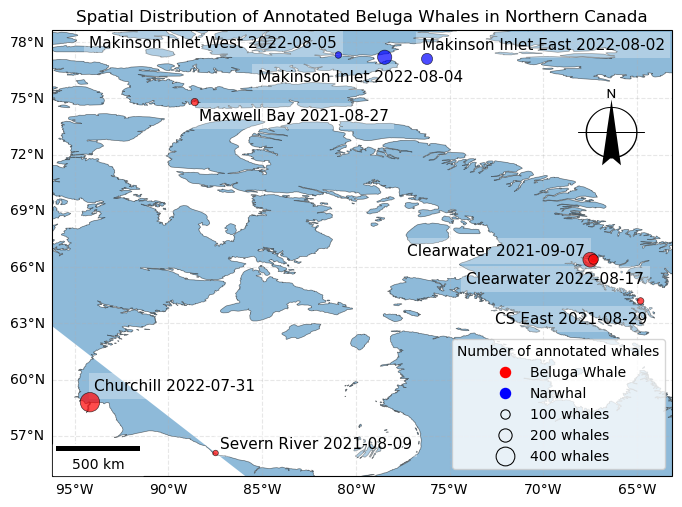

In [5]:
# Read Image_list.xlsx
whale_list = pd.read_excel(r"C:\Users\zyj19\Desktop\Whales\DFO\Imagery list.xlsx", sheet_name='AOI')

fig, ax = plt.subplots(figsize=(8, 8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
coastline = NaturalEarthFeature('physical', 'coastline', '10m')
ax.add_feature(coastline, edgecolor='black', linewidth=0.5, alpha=0.5)

# Add research area data
for index, row in whale_list.iterrows():
    location = row['Location']
    # if location not in ['Churchill', 'Clearwater']:
    #     continue
    date = row['Date'].date() 
    num_whales = row['Whale']
    # color = 'r' if row['Sat'] == 'WV3' else 'b'
    color = 'r' if row['Species'] == 'Beluga' else 'b'
    centroid_x, centroid_y = row['Centroid_x'], row['Centroid_y']
    offset_x, offset_y = row['Offset_x'], row['Offset_y']

    radius = np.sqrt(num_whales) * 0.025
    circle = Circle((centroid_x, centroid_y), radius, facecolor=color, edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree(), alpha=0.7, zorder=5)
    ax.add_patch(circle)

    text = ax.annotate(f'{location} {date}', xy=(centroid_x+offset_x, centroid_y+offset_y), xytext=(3, 3),
                       textcoords='offset points', fontsize=11, ha='left', transform=ccrs.PlateCarree(), 
                       bbox=dict(facecolor='white', alpha=0.3, edgecolor='none'))

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='r', label='Beluga Whale', markersize=marker_size(100, ax, fig), markeredgewidth=1.5, linestyle='None'),
    plt.Line2D([0], [0], marker='o', color='b', label='Narwhal', markersize=marker_size(100, ax, fig), markeredgewidth=1.5, linestyle='None'),
    plt.Line2D([0], [0], marker='o', color='w', markeredgecolor='black', label='100 whales', markersize=marker_size(100, ax, fig), markerfacecolor='none', markeredgewidth=0.75, linestyle='None'),
    plt.Line2D([0], [0], marker='o', color='w', markeredgecolor='black', label='200 whales', markersize=marker_size(200, ax, fig), markerfacecolor='none', markeredgewidth=0.75, linestyle='None'),
    plt.Line2D([0], [0], marker='o', color='w', markeredgecolor='black', label='400 whales', markersize=marker_size(400, ax, fig), markerfacecolor='none', markeredgewidth=0.75, linestyle='None'),
]
ax.legend(handles=legend_elements, title='Number of annotated whales', loc='lower right')

# Add scalebar
scalebar = ScaleBar(distance_meters, units='m', dimension='si-length', location='lower left', scale_loc='bottom', frameon=True)
ax.add_artist(scalebar)

# Add north arrow
x, y = 0.9, 0.8
esri_north_font_path = r"C:\Users\zyj19\Desktop\Projects\ESRI North Regular.ttf"
ax.text(x, y, 'o', fontsize=80, fontproperties=fm.FontProperties(fname=esri_north_font_path),
        transform=ax.transAxes, ha='center', va='center', color='black')

# Add gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.title('Spatial Distribution of Annotated Beluga Whales in Northern Canada')
plt.show()
# fig.savefig('sample distribution.png')